In [3]:
import argparse
import builtins
import math
import os
import random
import shutil
import time
import warnings

import numpy as np
import scanpy as sc
import scipy.sparse as sps

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.multiprocessing as mp
import torch.utils.data
import torch.utils.data.distributed

import sys
from pathlib import Path
from os.path import join
cur_dir = Path(os.getcwd())
sys.path.append(str(cur_dir.parent.absolute()))

import moco.builder
from moco.builder import ClaireNet
from moco.base_encoder import Encoder, EncoderL2
from moco.config import Config
from moco.dataset_optim import ClaireDataset, print_AnchorInfo
from moco.preprocessing import embPipe

from moco.trainval import load_ckpt, evaluate, train, save_checkpoint, get_args, adjust_learning_rate

import matplotlib.pyplot as plt

In [4]:
from args import Args

configs = Config()

args = Args()

##========================
args.dname = 'PBMC'    # set data folder name here

args.anchor_schedule = [10]
args.schedule = [10]

print_freq = args.print_freq

# set training environ
os.environ['CUDA_VISIBLE_DEVICES'] = args.gpu

# set logging dir
sane_ps = 'optim_'   
sane_ps += f'knn={args.knn}_alpha={args.alpha}_augSet={args.augment_set}_'   # for construction strategy
sane_ps += f'anc-schedl={args.anchor_schedule}_filter={args.fltr}_yita={args.yita}_'   # for refinment strategy
sane_ps += f'eps={args.epochs}_lr={args.lr}_batch-size={args.batch_size}_'   # training params
sane_ps += f'adjustLr={args.adjustLr}_schedule={args.schedule}'             # training params

log_dir = join(configs.out_root, f'{args.dname}/{sane_ps}')
os.makedirs(log_dir, exist_ok=True)

# Training

In [5]:
ri = 0 # repeated experiment
os.makedirs(join(log_dir, f'weights{ri+1}'), exist_ok=True)     # folder used to save model weights
os.makedirs(join(log_dir, f'results{ri+1}'), exist_ok=True)     # folder to save lossCurve and umap results

# Data loading code
traindir = os.path.join(configs.data_root, args.dname)
train_dataset = ClaireDataset(
    traindir,
    mode='train',
    select_hvg=args.select_hvg,
    scale=False,
    knn=args.knn,
    alpha=args.alpha,
    augment_set=args.augment_set,
    exclude_fn=(args.dname!='MouseCellAtlas'),
    verbose=1
    )
val_dataset = ClaireDataset(
    traindir,
    mode='val',
    select_hvg=args.select_hvg,
    scale=False,
    knn=args.knn,
    alpha=args.alpha,
    verbose=0
    )

assert np.all(train_dataset.gname == val_dataset.gname), 'unmatched gene names'
assert np.all(train_dataset.cname == val_dataset.cname), 'unmatched cell names'
val_dataset.X = train_dataset.X  # eliminate randomness in preprocessing steps
train_steps = train_dataset.n_sample // args.batch_size

val_loader = torch.utils.data.DataLoader(
        val_dataset, 
        batch_size=args.batch_size, 
        num_workers=args.workers, 
        shuffle=False, 
        drop_last=False)

model = ClaireNet(
    base_encoder=EncoderL2,
    in_dim=train_dataset.n_feature,
    lat_dim=args.lat_dim, 
    block_level=args.block_level,
    args=args
) 

model = model.cuda()

if args.optim=='Adam':
    optimizer = torch.optim.Adam(model.parameters(), args.lr,
                                # momentum=args.momentum,
                                weight_decay=args.weight_decay)
elif args.optim=='SGD':
    optimizer = torch.optim.SGD(model.parameters(), args.lr,
                                momentum=args.momentum,
                                weight_decay=args.weight_decay)

cudnn.benchmark = True

# start training
if not args.skip_training:
    print('==========>Start training<==========')
    loss = []
    for epoch in range(args.start_epoch, args.epochs):
        if args.adjustLr:
            adjust_learning_rate(optimizer, epoch, args)

        if epoch in args.anchor_schedule:
            print(f'================== Anchor schedule {epoch}')
            lat_emb, latl2_emb = evaluate(val_loader, model, args)

            print('filtering anchors')
            train_dataset.filter_anchors(latl2_emb,  
                                        fltr=args.fltr,
                                        yita=args.yita
                                        )


            train_dataset.exclude_sampleWithoutMNN(True)
            train_dataset.getMnnDict()

            if train_dataset.type_label is not None:
                print_AnchorInfo(train_dataset.pairs, train_dataset.batch_label, train_dataset.type_label)


        # train one epoch
        train_dataset.update_pos_nn_info()
        train_loader = torch.utils.data.DataLoader(
                                                    train_dataset, 
                                                    batch_size=args.batch_size, 
                                                    num_workers=args.workers, 
                                                    shuffle=True, 
                                                    drop_last=True)
        lossi = train(train_loader, model, optimizer, epoch, args)
        loss.append(lossi)

        if (epoch+1) % args.save_freq == 0:
            save_checkpoint({
                'epoch': epoch + 1,
                # 'arch': args.arch,
                'state_dict': model.state_dict(),
                'optimizer' : optimizer.state_dict(),
            }, is_best=False, filename=join(log_dir, 'weights{}/checkpoint_{:04d}.pth.tar'.format(ri+1, epoch+1)))

    # fig = plt.plot(loss, label='loss')
    np.save(join(log_dir, f'results{ri+1}/loss.npy'), loss)

The reading cost time 0.1875 secs
The reading cost time 0.0783 secs


... storing 'Sample' as categorical
... storing 'n_counts' as categorical
... storing 'n_genes' as categorical
... storing 'batch' as categorical
... storing 'louvain' as categorical
... storing 'anno' as categorical
... storing 'Method' as categorical
/home/yxh/anaconda3/envs/torch171/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Defined ops:  ['int']
loading anchors from  /home/yxh/gitrepo/Batch-effect-removal-benchmarking-master/Script/sapling/GLOBE/data/PBMC/seuratAnchors.csv
Anchors n=8162, ratio=0.9614
batch
Batch1    0.546184
Batch2    0.527650
dtype: float64
type
B cell                         0.526782
CD4 T cell                     0.584045
CD8 T cell                     0.577339
Hematopoietic stem cell        0.666667
Megakaryocyte                  0.471698
Monocyte_CD14                  0.413692
Monocyte_FCGR3A                0.643494
NK cell                        0.747049
Plasmacytoid dendritic cell    0.661871
dtype: float64
Number of training samples = 8316
Sample-wise knn ratio=0.9535
The reading cost time 0.0210 secs
The reading cost time 0.0192 secs


... storing 'Sample' as categorical
... storing 'n_counts' as categorical
... storing 'n_genes' as categorical
... storing 'batch' as categorical
... storing 'louvain' as categorical
... storing 'anno' as categorical
... storing 'Method' as categorical
/home/yxh/anaconda3/envs/torch171/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


==========>Start training<==========
Epoch: [0][ 9/32]	Time  0.019 ( 0.061)	Data  0.001 ( 0.039)	Loss 7.3217e+00 (6.4775e+00)
Epoch: [0][19/32]	Time  0.024 ( 0.041)	Data  0.004 ( 0.021)	Loss 7.1499e+00 (6.8538e+00)
Epoch: [0][29/32]	Time  0.021 ( 0.035)	Data  0.004 ( 0.015)	Loss 7.1689e+00 (6.9376e+00)
Epoch: [1][ 9/32]	Time  0.019 ( 0.057)	Data  0.001 ( 0.036)	Loss 7.0395e+00 (7.0188e+00)
Epoch: [1][19/32]	Time  0.022 ( 0.040)	Data  0.004 ( 0.020)	Loss 6.9907e+00 (6.9824e+00)
Epoch: [1][29/32]	Time  0.024 ( 0.035)	Data  0.003 ( 0.015)	Loss 6.9016e+00 (6.9620e+00)
Epoch: [2][ 9/32]	Time  0.019 ( 0.055)	Data  0.001 ( 0.035)	Loss 6.8952e+00 (6.8525e+00)
Epoch: [2][19/32]	Time  0.026 ( 0.038)	Data  0.004 ( 0.019)	Loss 6.8442e+00 (6.8386e+00)
Epoch: [2][29/32]	Time  0.026 ( 0.034)	Data  0.005 ( 0.014)	Loss 6.7876e+00 (6.8188e+00)
Epoch: [3][ 9/32]	Time  0.028 ( 0.058)	Data  0.002 ( 0.035)	Loss 6.7877e+00 (6.7641e+00)
Epoch: [3][19/32]	Time  0.029 ( 0.042)	Data  0.006 ( 0.020)	Loss 6.7242e+

# Inference

=> loaded checkpoint: checkpoint_0010.pth.tar
=> loaded checkpoint: checkpoint_0020.pth.tar
=> loaded checkpoint: checkpoint_0040.pth.tar
=> loaded checkpoint: checkpoint_0080.pth.tar
=> loaded checkpoint: checkpoint_0120.pth.tar
=====================> 10


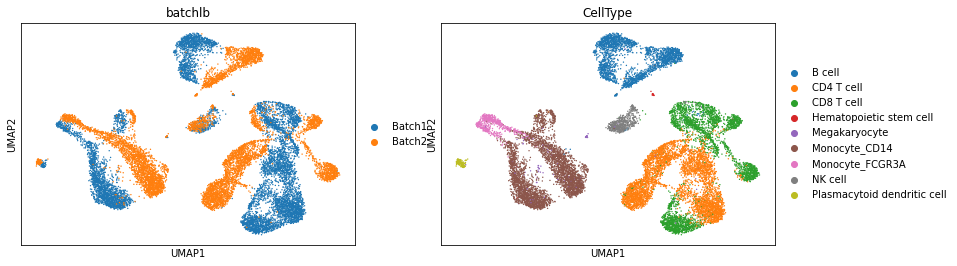

=====================> 20


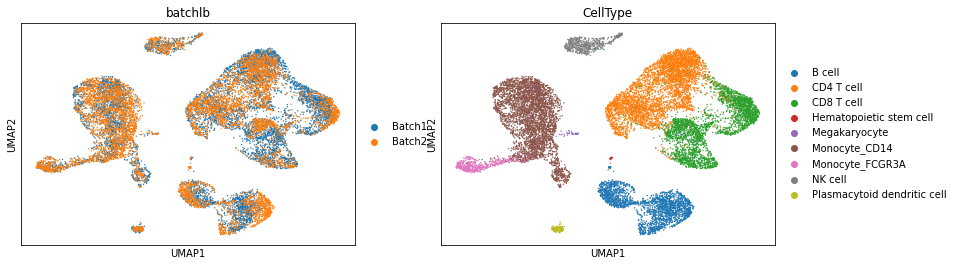

=====================> 40


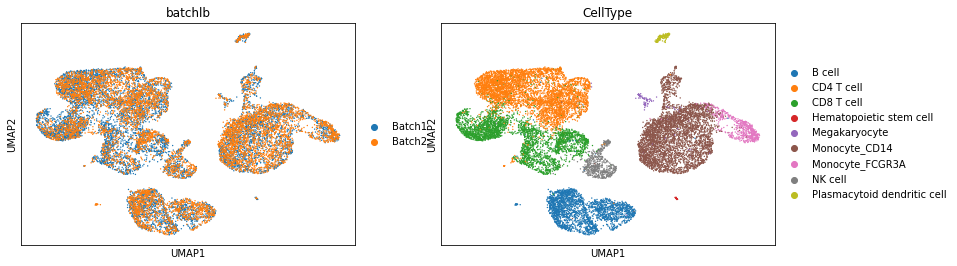

=====================> 80


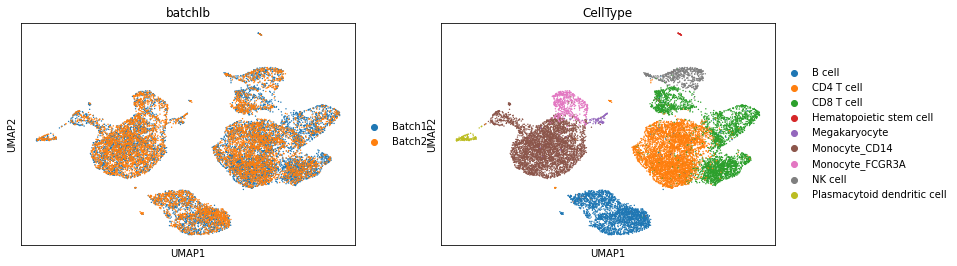

=====================> 120


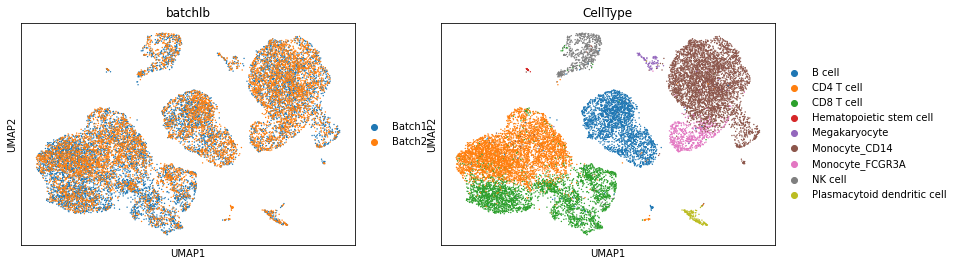

In [6]:
# inference with specified checkpoints
args.visualize_ckpts = list(filter(lambda x: x<=args.epochs, args.visualize_ckpts))

tmp_emb = {}
for idx in args.visualize_ckpts:
    if idx > args.epochs: 
        continue
        
    model = load_ckpt(model, join(log_dir, f'weights{ri+1}'), idx)
    lat_emb, latl2_emb = evaluate(val_loader, model, args)

    ad_lat = embPipe(latl2_emb, train_dataset.metadata) 
#     ad_lat.write(join(log_dir, f'results{ri+1}/ad_{idx}.h5ad'))

    tmp_emb[idx] = ad_lat 

# saving plot
for i, idx in enumerate(args.visualize_ckpts):
    print(f'=====================> {idx}')

    sc.pl.umap(tmp_emb[idx], color=[configs.batch_key, configs.label_key])

# Label Transfer

### 1. 'Batch 1' -> 'Batch 2'

In [18]:
from moco.knn_classifier import knn_classifier_top_k, knn_classifier_eval

adata_embedding = tmp_emb[40]
X_reference = adata_embedding[adata_embedding.obs.batchlb == 'Batch1'].X.copy()
X_query     = adata_embedding[adata_embedding.obs.batchlb == 'Batch2'].X.copy()

Y_reference = np.array(adata_embedding[adata_embedding.obs.batchlb == 'Batch1'].obs.CellType.values)
Y_query     = np.array(adata_embedding[adata_embedding.obs.batchlb == 'Batch2'].obs.CellType.values)

closed_mask = np.in1d(Y_query, np.unique(Y_reference))

knn_pr = knn_classifier_top_k(X_reference, X_query, Y_reference, n_sample=None, knn=10, top_k=1)
acc = knn_classifier_eval(knn_pr, Y_query, top_k=1, mask=closed_mask)

acc

kNN Search done in 0 seconds


0.9705882352941176

### 2. 'Batch 2' -> 'Batch 1'

In [20]:
from moco.knn_classifier import knn_classifier_top_k, knn_classifier_eval

adata_embedding = tmp_emb[40]
X_reference = adata_embedding[adata_embedding.obs.batchlb == 'Batch2'].X.copy()
X_query     = adata_embedding[adata_embedding.obs.batchlb == 'Batch1'].X.copy()

Y_reference = np.array(adata_embedding[adata_embedding.obs.batchlb == 'Batch2'].obs.CellType.values)
Y_query     = np.array(adata_embedding[adata_embedding.obs.batchlb == 'Batch1'].obs.CellType.values)

closed_mask = np.in1d(Y_query, np.unique(Y_reference))

knn_pr = knn_classifier_top_k(X_reference, X_query, Y_reference, n_sample=None, knn=10, top_k=1)
acc = knn_classifier_eval(knn_pr, Y_query, top_k=1, mask=closed_mask)

acc

kNN Search done in 0 seconds


0.9614719683872561

In [22]:
(0.971 + 0.961) / 2

0.966